# Introduction to Spark ML: An application to Sentiment Analysis

# Spark ML

In previous versions of Spark, most Machine Learning funcionality was provided through RDD (Resilient Distributed Datasets). However, to improve performance and communicability of results, Spark developers ported the ML functionality to work almost exclusively with DataFrames. Future releases of Spark will not update the support of ML with RDDs.

In this modern Spark ML approach, there are _Estimators_ and _Transformers_. Estimators have some parameters that need to be fit into the data. After fitting, Estimators return Transformers. Tranformers can be applied to dataframes, taking one (or several) columns as input and creating none (or several) columns as output.

A _Pipeline_ combines several _Tranformers_ with a final _Estimator_. The _Pipeline_, therefore, can be fit to the data because the final step of the process (the _Estimator_) is fit to the data. The result of the fitting is a pipelined _Transformer_ that takes an input dataframe through all the stages of the Pipeline.

There is a third type of functionality that allows to select features.

For example, for analyzing text, a typical pipelined estimator is as follows:

<img src="http://spark.apache.org/docs/latest/img/ml-Pipeline.png" alt="ML Pipeline" style="width: 100%;"/>

After fitting, the Pipeline becomes a transformer:

<img src="http://spark.apache.org/docs/latest/img/ml-PipelineModel.png" alt="ML Model" style="width: 100%;"/>
(Images from http://spark.apache.org/docs/latest/ml-pipeline.html)

Importantly, transformers can be saved and exchanged with other data scientists, improving reproducibility.

## Loading packages and connecting to Spark cluster

In [1]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
import os
def is_databricks():
    if os.getenv("DATABRICKS_RUNTIME_VERSION") != None:
        return True
    else:
        return False

# Define a function to read the data. The full path name is constructed by checking
# the runtime environment to determine if it is databricks or a personal computer.
# On the local filesystem the data is assumed to be in the same directory as the code.
# On databricks, the data path is assumed to be at '/FileStore/tables/' location.
# 
# Parameter(s):
#   name: The base name of the file, parquet file or parquet directory
# Return Value:
#   full_path_name: the full path name of the data based on the runtime environment
#
# Correct Usage Example (pass ONLY the full file name):
#   name_to_load = get_datapath("sms_spam.csv") # correct  
#   
# Incorrect Usage Examples:
#   name_to_load = get_datapath("/sms_spam.csv") # incorrect
#   name_to_load = get_datapath("sms_spam.csv/") # incorrect
#   name_to_load = get_datapath("c:/users/will/data/sms_spam.csv") incorrect
#
def get_datapath(name):    
    if is_databricks():
        full_path_name = "/FileStore/tables/%s" % name
    else:
        full_path_name = name
    return full_path_name

Define a function to read a parquet file and return a dataframe.  If we are running on databricks, the parquet files will be read from the databricks data directory.  Otherwise, the parquet files are assumed to be in the same directory as this notebook. You may change this function if you store the parquet files elsewhere. Note that parquet files are often represented as directories

In [3]:
def read_parquet(parquet_file_name):
    return spark.read.parquet(get_datapath(parquet_file_name))

### Transformers and Estimators

Let's define an example dataframe with documents

In [4]:
documents_df = spark.sparkContext.parallelize([
        [1, 'cats cats are cute', 0],
        [2, 'dogs are playfull', 0],
        [3, 'lions are big', 1],
        [4, 'cars are fast', 1]]).toDF(['doc_id', 'text', 'user_id'])
documents_df.toPandas()

,doc_id,text,user_id
0,1,cats cats are cute,0
1,2,dogs are playfull,0
2,3,lions are big,1
3,4,cars are fast,1


There are several ways of transforming the data from raw input to something that can be analyzed with a statistical model.

Some examples of such transformers are displayed below:

#### Tokenizer

Suppose that we want to split the document into separate words where each word is a _token_. This is what `Tokenizer` does.

In [5]:
from pyspark.ml.feature import Tokenizer

Almost all transfomers and estimators require you to specificy the input column of the dataframe and the output column that will be added to the dataframe.

In [6]:
# the tokenizer object
tokenizer = Tokenizer().setInputCol('text').setOutputCol('words')

We can now transform the dataframe

In [7]:
tokenizer.transform(documents_df).show()

+------+------------------+-------+--------------------+
|doc_id|              text|user_id|               words|
+------+------------------+-------+--------------------+
|     1|cats cats are cute|      0|[cats, cats, are,...|
|     2| dogs are playfull|      0|[dogs, are, playf...|
|     3|     lions are big|      1|   [lions, are, big]|
|     4|     cars are fast|      1|   [cars, are, fast]|
+------+------------------+-------+--------------------+



#### CountVectorizer

This transformer counts how many times a word appears in a list and produces a vector with such counts. This is very useful for text analysis.

In [8]:
from pyspark.ml.feature import CountVectorizer

A `CountVectorizer` is different from a `Tokenizer` because it needs to learn how many different tokens there are in the input column. With that number, it will output vectors with consistent dimensions. Therefore, `CountVectorizer` is an `Estimator` that, when fitted, returns a `Transformer`.

In [9]:
count_vectorizer_estimator = CountVectorizer().setInputCol('words').setOutputCol('features')

Now we need to use the words column that was generated by the `tokenizer` transformer

In [10]:
count_vectorizer_transformer = count_vectorizer_estimator.fit(tokenizer.transform(documents_df))

which results in:

In [11]:
count_vectorizer_transformer.transform(tokenizer.transform(documents_df)).show(truncate=False)

+------+------------------+-------+-----------------------+-------------------------+
|doc_id|text              |user_id|words                  |features                 |
+------+------------------+-------+-----------------------+-------------------------+
|1     |cats cats are cute|0      |[cats, cats, are, cute]|(9,[0,1,3],[1.0,2.0,1.0])|
|2     |dogs are playfull |0      |[dogs, are, playfull]  |(9,[0,2,5],[1.0,1.0,1.0])|
|3     |lions are big     |1      |[lions, are, big]      |(9,[0,4,8],[1.0,1.0,1.0])|
|4     |cars are fast     |1      |[cars, are, fast]      |(9,[0,6,7],[1.0,1.0,1.0])|
+------+------------------+-------+-----------------------+-------------------------+



The column `features` is a sparse vector representation. For example, assume that the first document (document id 1) has the following features: 

(9,[0,1,6],[1.0,2.0,1.0]) 

The '9' indicates that there are a total of 9 features or words.

The \[0,1,6] indicates that the words in this document correspond to vocabulary indices (see vocabulary below) 0, 1, and 6.  Note that this mapping can change from run to run.  By looking at the vocabulary learned by `count_vectorizer_transformer`, we can look up which words those feature indices refer to.

The \[1.0,2.0,1.0] indicates the count of each word in the document.

In [12]:
# list of words in the vocabulary
count_vectorizer_transformer.vocabulary

['are', 'cats', 'playfull', 'cute', 'lions', 'dogs', 'cars', 'fast', 'big']

In the cell below, we transform using a new dataframe which has an unseen word `lizard`.  Notice that lizard does not appear in the vocabulary that was present during the fit operation above.  Since lizard is not included in the vocabulary, the features column in row 1 does not include lizard in the features.  In fact, the features col of row 1 indicates that only 2 words are present when in fact there is 3 words present.  There are only 2 words present in the features column because the word `lizard` was not present during the fit operation.  This allows us to train a model and then make predictions on unseen data that might contain some words that were not present during the fit process.  In this notebook, we will train a model using IMDB movie data and then make predictions on tweets from the 2016 election using the same model trained on IMDB data. 

In [13]:
# create a new dataframe that contains an unseen word 'lizard'
documents_df1 = spark.sparkContext.parallelize([
        [1, 'lizards are cute', 0],
        [2, 'dogs are playfull', 0],
        [3, 'lions are big', 1],
        [4, 'cars are fast', 1]]).toDF(['doc_id', 'text', 'user_id'])

# transform the new dataframe and notice that lizard is not in the feature data
count_vectorizer_transformer.transform(tokenizer.transform(documents_df1)).show(truncate=False)

# print the vocabulary created during the fit process, notice that lizard is not present
print(count_vectorizer_transformer.vocabulary)

+------+-----------------+-------+---------------------+-------------------------+
|doc_id|text             |user_id|words                |features                 |
+------+-----------------+-------+---------------------+-------------------------+
|1     |lizards are cute |0      |[lizards, are, cute] |(9,[0,3],[1.0,1.0])      |
|2     |dogs are playfull|0      |[dogs, are, playfull]|(9,[0,2,5],[1.0,1.0,1.0])|
|3     |lions are big    |1      |[lions, are, big]    |(9,[0,4,8],[1.0,1.0,1.0])|
|4     |cars are fast    |1      |[cars, are, fast]    |(9,[0,6,7],[1.0,1.0,1.0])|
+------+-----------------+-------+---------------------+-------------------------+

['are', 'cats', 'playfull', 'cute', 'lions', 'dogs', 'cars', 'fast', 'big']


## Pipelines

Sometimes, we have long preprocessing steps that take raw data and transform it through several stages. As explained before, these complex transformations can be captured by Pipelines.

Pipelines are always estimators, even when they contain several transformers. After a pipeline is `fit` to the data, the pipeline becomes a transformer.

We will now define a pipeline that takes the raw `text` column and produces the `features` column previously explained

In [14]:
from pyspark.ml import Pipeline

In [15]:
pipeline_cv_estimator = Pipeline(stages=[tokenizer, count_vectorizer_estimator])

In [16]:
pipeline_cv_transformer = pipeline_cv_estimator.fit(documents_df)

In [17]:
pipeline_cv_transformer.transform(documents_df).show()

+------+------------------+-------+--------------------+--------------------+
|doc_id|              text|user_id|               words|            features|
+------+------------------+-------+--------------------+--------------------+
|     1|cats cats are cute|      0|[cats, cats, are,...|(9,[0,1,6],[1.0,2...|
|     2| dogs are playfull|      0|[dogs, are, playf...|(9,[0,3,8],[1.0,1...|
|     3|     lions are big|      1|   [lions, are, big]|(9,[0,4,7],[1.0,1...|
|     4|     cars are fast|      1|   [cars, are, fast]|(9,[0,2,5],[1.0,1...|
+------+------------------+-------+--------------------+--------------------+



In more complex scenarios, you can even chain Pipeline transformers. We will see this case in the actual use case below.

For a more detail explanation of Pipelines, Estimators, and Transformers, [see here](http://spark.apache.org/docs/latest/ml-pipeline.html)

## Load sentiment data

In [18]:
sentiments_df = read_parquet('sentiments.parquet')

In [19]:
sentiments_df.printSchema()

root
 |-- word: string (nullable = true)
 |-- sentiment: long (nullable = true)



In [20]:
sentiments_df.show(5)

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



The schema is very simple: for each word, we have whether it is positive (+1) or negative (-1)

In [21]:
# a sample of positive words
sentiments_df.where(fn.col('sentiment') == 1).show(5)

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



In [22]:
# a sample of negative words
sentiments_df.where(fn.col('sentiment') == -1).show(5)

+----------+---------+
|      word|sentiment|
+----------+---------+
|   2-faced|       -1|
|   2-faces|       -1|
|  abnormal|       -1|
|   abolish|       -1|
|abominable|       -1|
+----------+---------+
only showing top 5 rows



Lets see how many of each category we have

In [23]:
sentiments_df.groupBy('sentiment').agg(fn.count('*')).show()

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|        1|    2006|
|       -1|    4783|
+---------+--------+



We have almost two times the number of negative words!

# A simple approach to sentiment analysis

One simple approach for sentiment analysis is to simply count the number of positive and negative words in a text and then compute the average sentiment. Assuming that positive words are +1 and negative words are -1, we can classify a text as positive if the average sentiment is greater than zero and negative otherwise

To test our approach, we will use a sample of [IMDB](http://www.imdb.com/) reviews that were tagged as positive and negative.

Let's load them:

In [24]:
imdb_reviews_df = read_parquet('imdb_reviews_preprocessed.parquet')
imdb_reviews_df.show(10)

+---------+--------------------+-----+
|       id|              review|score|
+---------+--------------------+-----+
|pos_10006|In this "critical...|  1.0|
|pos_10013|Like one of the p...|  1.0|
|pos_10022|Aro Tolbukhin bur...|  1.0|
|pos_10033|The movie Titanic...|  1.0|
| pos_1003|Another Aussie ma...|  1.0|
| pos_1004|After a brief pro...|  1.0|
|pos_10053|I must admit, whe...|  1.0|
|pos_10062|Wow. What a wonde...|  1.0|
|pos_10074|quote by Nicolas ...|  1.0|
|pos_10083|The fact that thi...|  1.0|
+---------+--------------------+-----+
only showing top 10 rows



Print the unique scores in the imdb_reviews_df.  A positive review has a score of 1, and a negative review has a score of 0.

In [25]:
imdb_reviews_df.toPandas()['score'].unique()

array([1., 0.])

Let's take a look at a positive review

In [26]:
imdb_reviews_df.where(fn.col('score') == 1).first()

Row(id='pos_10006', review='In this "critically acclaimed psychological thriller based on true events, Gabriel (Robin Williams), a celebrated writer and late-night talk show host, becomes captivated by the harrowing story of a young listener and his adoptive mother (Toni Collette). When troubling questions arise about this boy\'s (story), however, Gabriel finds himself drawn into a widening mystery that hides a deadly secret\x85" according to film\'s official synopsis.<br /><br />You really should STOP reading these comments, and watch the film NOW...<br /><br />The "How did he lose his leg?" ending, with Ms. Collette planning her new life, should be chopped off, and sent to "deleted scenes" land. It\'s overkill. The true nature of her physical and mental ailments should be obvious, by the time Mr. Williams returns to New York. Possibly, her blindness could be in question - but a revelation could have be made certain in either the "highway" or "video tape" scenes. The film would benefi

And a negative one

In [27]:
imdb_reviews_df.where(fn.col('score') == 0).first()

Row(id='neg_10006', review="I don't know who to blame, the timid writers or the clueless director. It seemed to be one of those movies where so much was paid to the stars (Angie, Charlie, Denise, Rosanna and Jon) that there wasn't enough left to really make a movie. This could have been very entertaining, but there was a veil of timidity, even cowardice, that hung over each scene. Since it got an R rating anyway why was the ubiquitous bubble bath scene shot with a 70-year-old woman and not Angie Harmon? Why does Sheen sleepwalk through potentially hot relationships WITH TWO OF THE MOST BEAUTIFUL AND SEXY ACTRESSES in the world? If they were only looking for laughs why not cast Whoopi Goldberg and Judy Tenuta instead? This was so predictable I was surprised to find that the director wasn't a five year old. What a waste, not just for the viewers but for the actors as well.", score=0.0)

The first problem that we encounter is that the reviews are in plain text. We need to split the words and then match them to `sentiment_df`.  To do this, we will use a transformation that takes raw text and outputs a list of words

In [28]:
from pyspark.ml.feature import RegexTokenizer

`RegexTokenizer` extracts a sequence of matches from the input text. Regular expressions are a powerful tool to extract strings with certain characteristics.  The pattern `\p{L}+` means that it will extract letters without accents (e.g., it will extract "Acuna" from "Acuña"). `setGaps=False` means that it will keep applying the rule until it can't extract new words. You have to set the input column from the incoming dataframe (in our case the `review` column) and the new column that will be added (e.g., `words`).

In [29]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("review")\
  .setOutputCol("words")

In [30]:
review_words_df = tokenizer.transform(imdb_reviews_df)
print(review_words_df)

DataFrame[id: string, review: string, score: double, words: array<string>]


Applying the transformation doesn't actually do anything until you apply an action. But as you can see, a new column `words` of type `array` of `string` was added by the transformation. We can see how it looks:

In [31]:
review_words_df.show(5)

+---------+--------------------+-----+--------------------+
|       id|              review|score|               words|
+---------+--------------------+-----+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|
+---------+--------------------+-----+--------------------+
only showing top 5 rows



Now, we want to match every word from `sentiment_df` in the array `words` shown before. One way of doing this is to _explode_ the column `words` to create a row for each element in that list. Then, we would join that result with the dataframe `sentiment` to continue further.

In [32]:
review_words_df.select('id', fn.explode('words').alias('word1')).show(5)

+---------+-------------+
|       id|        word1|
+---------+-------------+
|pos_10006|           in|
|pos_10006|         this|
|pos_10006|   critically|
|pos_10006|    acclaimed|
|pos_10006|psychological|
+---------+-------------+
only showing top 5 rows



Now if we join that with sentiment, we can see if there are positive and negative words in each review:

In [33]:
review_word_sentiment_df = review_words_df.\
    select('id', fn.explode('words').alias('word')).\
    join(sentiments_df, 'word')
review_word_sentiment_df.show(5)

+----------+---------+---------+
|      word|       id|sentiment|
+----------+---------+---------+
| acclaimed|pos_10006|        1|
|celebrated|pos_10006|        1|
| troubling|pos_10006|       -1|
|   mystery|pos_10006|       -1|
|    deadly|pos_10006|       -1|
+----------+---------+---------+
only showing top 5 rows



Check the unique sentiment column values.  Sentiments should be +1 and -1 for positive and negative word sentiments respectively.

In [34]:
review_word_sentiment_df.toPandas()['sentiment'].unique()

array([ 1, -1], dtype=int64)

Now we can simply average the sentiment per review id and, say, pick positive when the average is above 0, and negative otherwise.

In [35]:
simple_sentiment_prediction_df = review_word_sentiment_df.\
    groupBy('id').\
    agg(fn.avg('sentiment').alias('avg_sentiment')).\
    withColumn('predicted', fn.when(fn.col('avg_sentiment') > 0, 1.0).otherwise(0.))
simple_sentiment_prediction_df.show(5)

+---------+--------------------+---------+
|       id|       avg_sentiment|predicted|
+---------+--------------------+---------+
|pos_10149| 0.42857142857142855|      1.0|
|pos_10377|  0.5384615384615384|      1.0|
| pos_1299| 0.09090909090909091|      1.0|
| pos_2228|-0.14285714285714285|      0.0|
| pos_5052|  0.7777777777777778|      1.0|
+---------+--------------------+---------+
only showing top 5 rows



Now, lets compute the accuracy of our prediction

In [36]:
imdb_reviews_df.\
    join(simple_sentiment_prediction_df, 'id').\
    select(fn.expr('float(score == predicted)').alias('correct')).\
    select(fn.avg('correct')).\
    show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.732231471106131|
+-----------------+



Not bad with such a simple approach! But can we do better than this?

## A data-driven sentiment prediction

There are couple of problems with the previous approach:
1. Positive and negative words had the same weight (e.g., good == amazing)
1. While our dataset is artificially balanced (12500 positive and 12500 negative), there are usually more positive than negative reviews, and therefore we should bias our predictions towards positive ones.

We could use __data__ to estimate the sentiment that each word is contributing to the final sentiment of a review. Given that we are trying to predict negative and positve reviews, then we can use logistic regression for such binary prediction.

### From text to numerical features

One typical approach is to count how many times a word appears in the text and then perform a reweighting so that words that are very common are "counted" less.

In Spark, we can achieve this by using several transformers:

__Raw text => Tokens => Remove stop words => Term Frequency => Reweighting by Inverse Document frequency__

To perform this sequence we will create a __`Pipeline`__ to consistently represent the steps from raw text to TF-IDF.

First, we need to create a sequence to take from raw text to term frequency. This is necessary because we don't know the number of tokens in the text and therefore we need to _estimate_ such quantity from the data.

In [37]:
# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [38]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

Finally, for this initial `Pipeline`, we define a counter vectorizer estimator

In [39]:
from pyspark.ml.feature import CountVectorizer

# we will remove words that appear in 5 docs or less
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [40]:
# we now create a pipelined transformer
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(imdb_reviews_df)

In [41]:
# now we can make the transformation between the raw text and the counts
cv_pipeline.transform(imdb_reviews_df).show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|[critically, accl...|(26677,[0,1,3,4,5...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|[like, previous, ...|(26677,[1,2,3,4,5...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|[aro, tolbukhin, ...|(26677,[0,1,2,12,...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|[movie, titanic, ...|(26677,[0,1,2,3,4...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|[aussie, masterpi...|(26677,[4,5,9,24,...|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



The term frequency vector is represented with a sparse vector. We have 26,677 terms.

In [42]:
len(cv_pipeline.stages[-1].vocabulary)

26677

Finally, we build another pipeline that takes the output of the previous pipeline and _lowers_ the terms of documents that are very common.

In [43]:
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [44]:
idf_pipeline = Pipeline(stages=[cv_pipeline, idf]).fit(imdb_reviews_df)

In [45]:
idf_pipeline.transform(imdb_reviews_df).show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|               tfidf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|[critically, accl...|(26677,[0,1,3,4,5...|(26677,[0,1,3,4,5...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|[like, previous, ...|(26677,[1,2,3,4,5...|(26677,[1,2,3,4,5...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|[aro, tolbukhin, ...|(26677,[0,1,2,12,...|(26677,[0,1,2,12,...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|[movie, titanic, ...|(26677,[0,1,2,3,4...|(26677,[0,1,2,3,4...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|[aussie, masterpi...|(26677,[4,5,9,24,...|(26677,[4,5,9,24,...|
+---------+-----

Therefore, the `idf_pipeline` takes the raw text from the datafarme `imdb_reviews_df` and creates a feature vector called `tfidf`!

In [46]:
tfidf_df = idf_pipeline.transform(imdb_reviews_df)
pd_tfidf_df = tfidf_df.toPandas()
print("pd_tfidf_df shape =", pd_tfidf_df.shape)

pd_tfidf_df shape = (25000, 7)


In [47]:
lr_df = pd_tfidf_df[['score', 'tfidf']]
lr_df.head()

,score,tfidf
0,1.0,"(6.399789021643247, 1.5355439272599614, 0.0, 1..."
1,1.0,"(0.0, 0.6142175709039845, 1.9611159574304948, ..."
2,1.0,"(3.1998945108216237, 0.6142175709039845, 0.490..."
3,1.0,"(3.1998945108216237, 0.30710878545199227, 1.47..."
4,1.0,"(0.0, 0.0, 0.0, 0.0, 0.5028974533168351, 0.761..."


The cell below prints out the 'tf' and 'tfidf' columns for the first 10 rows of the tfidf_df.  Note that the tfidf column is transformed to account for the frequency with which the word appears in the corpus.  Words that appear more often are penalized more than words that do not appear as frequently in the corpus.

In [48]:
tfidf_df.toPandas().loc[:10, ['tf', 'tfidf']]

,tf,tfidf
0,"(12.0, 5.0, 0.0, 3.0, 1.0, 1.0, 0.0, 1.0, 1.0,...","(6.399789021643247, 1.5355439272599614, 0.0, 1..."
1,"(0.0, 2.0, 4.0, 1.0, 1.0, 3.0, 3.0, 0.0, 0.0, ...","(0.0, 0.6142175709039845, 1.9611159574304948, ..."
2,"(6.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(3.1998945108216237, 0.6142175709039845, 0.490..."
3,"(6.0, 1.0, 3.0, 7.0, 3.0, 2.0, 1.0, 0.0, 2.0, ...","(3.1998945108216237, 0.30710878545199227, 1.47..."
4,"(0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.5028974533168351, 0.761..."
5,"(14.0, 7.0, 1.0, 6.0, 2.0, 0.0, 2.0, 3.0, 1.0,...","(7.466420525250455, 2.149761498163946, 0.49027..."
6,"(6.0, 2.0, 3.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, ...","(3.1998945108216237, 0.6142175709039845, 1.470..."
7,"(6.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(3.1998945108216237, 0.0, 0.0, 1.1677330317010..."
8,"(4.0, 0.0, 0.0, 4.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(2.1332630072144156, 0.0, 0.0, 2.3354660634020..."
9,"(6.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","(3.1998945108216237, 0.30710878545199227, 0.0,..."


# Data science pipeline for estimating sentiments

First, let's split the data into training, validation, and testing.

In [49]:
training_df, validation_df, testing_df = imdb_reviews_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [50]:
training_df.toPandas().head()

,id,review,score
0,neg_100,OK its not the best film I've ever seen but at...,0.0
1,neg_10001,This film lacked something I couldn't put my f...,0.0
2,neg_10005,The second attempt by a New York intellectual ...,0.0
3,neg_10013,A worn-out plot of a man who takes the rap for...,0.0
4,neg_10014,I saw this movie at a drive-in in 1959. Until ...,0.0


In [51]:
[training_df.count(), validation_df.count(), testing_df.count()]

[14941, 7603, 2456]

One immediately apparent problem is that the number of features in the dataset is far larger than the number of training examples. This can lead to serious overfitting.

Let's look at this more closely. Let's apply a simple prediction model known as logistic regression.

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) will take the `tfidf` features and predict whether the review is positive (`score == 1`) or negative (`score == 0`).

In [52]:
from pyspark.ml.classification import LogisticRegression

In [53]:
lr = LogisticRegression().\
    setLabelCol('score').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

Lets create a pipeline transformation by chaining the `idf_pipeline` with the logistic regression step (`lr`)

In [54]:
lr_pipeline = Pipeline(stages=[idf_pipeline, lr]).fit(training_df)

Lets estimate the accuracy:

In [55]:
lr_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = score)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.8488754439037222|
+------------------+



The performance is much better than before.

The problem however is that we are overfitting because we have many features compared to the training examples:

For example, if we look at the weights of the features, there is a lot of noise:

In [56]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
print("num weights:", len(weights))
print("num rows:", validation_df.count())

coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})
coeffs_df.head()

num weights: 26677
num rows: 7603


,word,weight
0,br,-0.090375
1,s,0.072233
2,movie,-0.126480
3,film,0.260678
4,t,-0.577672


The most negative words are:

In [57]:
coeffs_df.sort_values('weight').head(5)

,word,weight
21106,hotness,-7.692052
20177,mugs,-7.140048
25160,implement,-6.914617
24424,muzzle,-6.186583
25062,octane,-4.982614


And the most positive:

In [58]:
coeffs_df.sort_values('weight', ascending=False).head(5)

,word,weight
20798,praiseworthy,6.086079
22188,apprehension,5.562840
25627,bop,4.925072
21133,shrieks,4.755516
13805,greeted,4.488143


But none of them make sense. What is happening? We are overfitting the data. Those words that don't make sense are capturing just noise in the reviews.

# Regularization

One way to prevent overfitting during training is to modify the loss function and penalize weight values that are too large.

There are two major regularization techniques, one based on penalizing the squared value of the weight (called L2 or ridge regularization) and another based on penalizing the absolute value of the weight (called L1 or lasso regularization).

The unregularized logistic regression loss function is:

\begin{equation}
L_\theta(p(X),Y) = - \left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log (1-p_\theta(X_i)) \right)
\end{equation}

where $p_\theta(\cdot)$ is the sigmoid function:

\begin{equation}
p_\theta(X) = \frac{1}{1+\exp(-(\theta_0 + \sum_{j>0} x_j \theta_j))}
\end{equation}

If we modify the loss function $L_\theta$ slightly

\begin{equation}
L_\theta^{\lambda}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log(1-p_\theta(X_i)) \right) + \lambda \sum_{j>0} \theta_j^2
\end{equation}

we obtain what is known as L2 regularization.

Notice how we increase the loss function by $\lambda$ times the square of the weights. In practice, this means that __we will think twice about increasing the importance of a feature__. This loss function will prevent the algorithm for fitting certain data points, such as outliers or noise, unless the decrease in loss for the data grants it. Also, notice that the penalization doesn't apply to the bias parameter $\theta_0$.

You can see more clearly the effect of such cost function when $\lambda$ goes to infinity: the features will not be used for predicting and only the bias term will matter! This prevents the algorithm from learning altogether, forcing it to underfit!

One problem with L2 regularization is that all weights go to zero uniformly. In a sense, all features will matter but less than with the unregularized loss function. This is a really strange because we do not want all features to matter. In sentiment analysis, we want to select certain features because we want to understand that only some words have effects on the sentiment.

A different modification of the original loss function can achieve this. This regularization is known as L1 or lasso reguarlization and penalizes the _absolute_ value of the weight

\begin{equation}
L_\theta^{\lambda}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log(1-p_\theta(X_i)) \right) + \lambda \sum_{j>0} \left| \theta_j \right|
\end{equation}

The practical effect of L1 regularization is that the difference between a feature having no importance vs some small importance is massively bigger than with L2 regularization. __Therefore, optimizing the L1 loss function usually brings some features to have exactly zero weight.__

One problem with L1 regularization is that it will never select more features than the number of examples. This is because it can always fit the training data perfectly when the number of features equals the number of examples. In our sentimental analysis, this is the case (there are more words than examples).

One way of remedying this is to have a combination of both L1 and L2. This is known as __elastic net regularization__. For this type of regularization, we have to pick a parameter ($\alpha$) deciding to consider L1 vs L2 regularization. If $\alpha=0$, then we choose L2, and if $\alpha=1$ we choose L1. For example, $\alpha=0.5$ means half L1 and half L2.

\begin{equation}
L_\theta^{\lambda,\alpha}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log (1-p_\theta(X_i)) \right) + \lambda \left[(1-\alpha) \sum_{j>0} \theta_j^2 + \alpha \sum_{j>0} \left| \theta_j \right| \right]
\end{equation}

Unfortunately, elastic net regularization comes with two additional parameters, $\lambda$ and $\alpha$, and we must either select them a priori or use the validation set to choose the best one.

## Spark allows us to fit elastic net regularization easily

In [59]:
lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('score').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

And we define a new Pipeline with all steps combined

In [60]:
en_lr_estimator = Pipeline(
    stages=[tokenizer, sw_filter, cv, idf, en_lr])

In [61]:
en_lr_pipeline = en_lr_estimator.fit(training_df)

Let's look at the performance

In [62]:
en_lr_pipeline.transform(validation_df).select(fn.avg(fn.expr('float(prediction = score)'))).show()

+--------------------------------+
|avg(float((prediction = score)))|
+--------------------------------+
|              0.8686044982243851|
+--------------------------------+



We improve performance slightly, but whats more important is that we improve the understanding of the word sentiments. Lets look at the weights:

In [63]:
en_weights = en_lr_pipeline.stages[-1].coefficients.toArray()
en_coeffs_df = pd.DataFrame({'word': en_lr_pipeline.stages[2].vocabulary, 'weight': en_weights})

The most negative words all make sense ("worst" is _actually_ more negative than than "worse")!

In [64]:
en_coeffs_df.sort_values('weight').head(15)

,word,weight
106,worst,-0.384882
266,waste,-0.353546
200,awful,-0.251542
12,bad,-0.247780
622,poorly,-0.220930
930,pointless,-0.206212
325,horrible,-0.200918
191,boring,-0.186781
238,terrible,-0.175316
1169,disappointment,-0.174776


Same thing with positive words

In [65]:
en_coeffs_df.sort_values('weight', ascending=False).head(15)

,word,weight
151,excellent,0.270914
11,great,0.263263
26,best,0.182658
205,wonderful,0.173381
1987,refreshing,0.168914
1356,wonderfully,0.151671
307,favorite,0.149470
225,perfect,0.142558
1697,delightful,0.130549
245,loved,0.128981


Are there words with _literarily_ zero importance for predicting sentiment? Yes, and most of them!

In [66]:
en_coeffs_df.query('weight == 0.0').shape

(19555, 2)

In fact, approximately 95% of features are not needed to achieve a __better__ performance than all previous models!

In [67]:
en_coeffs_df.query('weight == 0.0').shape[0]/en_coeffs_df.shape[0]

0.9518130932100267

Let's look at these _neutral_ words

In [68]:
en_coeffs_df.query('weight == 0.0').head(15)

,word,weight
0,br,0.0
3,film,0.0
5,like,0.0
9,story,0.0
10,really,0.0
13,people,0.0
16,way,0.0
17,movies,0.0
18,think,0.0
19,characters,0.0


But, did we choose the right $\lambda$ and $\alpha$ parameters? We should run an experiment where we try different combinations of them. Fortunately, Spark let us do this by using a grid - a method that generates combination of parameters.

In [69]:
from pyspark.ml.tuning import ParamGridBuilder

We need to build a new estimator pipeline

In [70]:
en_lr_estimator.getStages()

[RegexTokenizer_09cf84d40c78,
 StopWordsRemover_5bc3d5849001,
 CountVectorizer_55b680a110db,
 IDF_c9365dda69e0,
 LogisticRegression_7c589cc03d21]

In [71]:
grid = ParamGridBuilder().\
    addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
    addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()

This is the list of parameters that we will try:

In [72]:
grid

[{Param(parent='LogisticRegression_7c589cc03d21', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_7c589cc03d21', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_7c589cc03d21', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_7c589cc03d21', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
 {Param(parent='LogisticRegression_7c589cc03d21', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_7c589cc03d21', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.4},
 {Pa

In [73]:
all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = en_lr_estimator.fit(training_df, grid[j])
    all_models.append(model)

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9


In [74]:
# estimate the accuracy of each of them:
accuracies = [m.\
    transform(validation_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]

In [75]:
accuracies

[0.8550572142575299,
 0.8550572142575299,
 0.8550572142575299,
 0.8661054846771011,
 0.8729448901749309,
 0.8716296198868868,
 0.8687360252531895,
 0.8733394712613443,
 0.8601867683809022]

In [76]:
import numpy as np

In [77]:
best_model_idx = np.argmax(accuracies)
print("best model index =", best_model_idx)

best model index = 7


So the best model we found has the following parameters

In [78]:
grid[best_model_idx]

{Param(parent='LogisticRegression_7c589cc03d21', name='regParam', doc='regularization parameter (>= 0).'): 0.02,
 Param(parent='LogisticRegression_7c589cc03d21', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2}

In [79]:
best_model = all_models[best_model_idx]

In [80]:
accuracies[best_model_idx]

0.8733394712613443

In [81]:
# estimate generalization performance
best_model.\
    transform(testing_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    show()

+-----------------+
|         accuracy|
+-----------------+
|0.879071661237785|
+-----------------+



## Finally, predicting tweet sentiments

Now we can use this model to predict sentiments on Twitter

In [82]:
tweets_df = read_parquet('tweets.parquet')
tweets_df.show(5)

+--------------------+---------------+
|                text|         handle|
+--------------------+---------------+
|RT @ZekeJMiller: ...|@HillaryClinton|
|“She’s just out t...|@HillaryClinton|
|We're going to ma...|@HillaryClinton|
|Don't boo. Vote! ...|@HillaryClinton|
|This Republican d...|@HillaryClinton|
+--------------------+---------------+
only showing top 5 rows



We have 1K tweets from each candidate

In [83]:
tweets_df.groupby('handle').agg(fn.count('*')).show()

+----------------+--------+
|          handle|count(1)|
+----------------+--------+
| @HillaryClinton|    1000|
|@realDonaldTrump|    1000|
+----------------+--------+



We can now predict the sentiment of the Tweet using our best model, we need to rename the column so that it matches our previous pipeline (`review` => ...)

In [84]:
best_model.transform(tweets_df.withColumnRenamed('text', 'review')).select('handle', 'review', 'prediction').show()

+---------------+--------------------+----------+
|         handle|              review|prediction|
+---------------+--------------------+----------+
|@HillaryClinton|RT @ZekeJMiller: ...|       1.0|
|@HillaryClinton|“She’s just out t...|       0.0|
|@HillaryClinton|We're going to ma...|       0.0|
|@HillaryClinton|Don't boo. Vote! ...|       0.0|
|@HillaryClinton|This Republican d...|       0.0|
|@HillaryClinton|Hillary teamed up...|       0.0|
|@HillaryClinton|RT @mayaharris_: ...|       1.0|
|@HillaryClinton|"It was overwhelm...|       0.0|
|@HillaryClinton|Great step forwar...|       1.0|
|@HillaryClinton|"I feel like I'm ...|       1.0|
|@HillaryClinton|Nobody here was “...|       1.0|
|@HillaryClinton|For those few peo...|       1.0|
|@HillaryClinton|Remember, don't b...|       1.0|
|@HillaryClinton|Too many talented...|       1.0|
|@HillaryClinton|There are hundred...|       0.0|
|@HillaryClinton|It's 3:20am. As g...|       1.0|
|@HillaryClinton|Trump stood on a ...|       1.0|


Now, lets summarize our results in a graph!

In [85]:
%matplotlib inline

In [86]:
import seaborn

In [87]:
sentiment_pd = best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    groupby('handle').\
    agg(fn.avg('prediction').alias('prediction'), (2*fn.stddev('prediction')/fn.sqrt(fn.count('*'))).alias('err')).\
    toPandas()

In [88]:
sentiment_pd.head()

,handle,prediction,err
0,@HillaryClinton,0.845,0.022900
1,@realDonaldTrump,0.860,0.021956


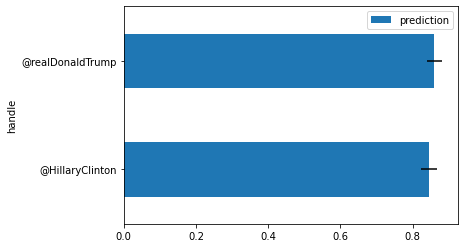

In [89]:
sentiment_pd.plot(x='handle', y='prediction', xerr='err', kind='barh');

But let's examine some "negative" tweets by Trump

In [90]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@realDonaldTrump').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review='Hillary is too weak to lead on border security-no solutions, no ideas, no credibility.She supported NAFTA, worst deal in US history. #Debate'),
 Row(review='Tune in at https://t.co/Q08Kp4w3oT and get the word out #BigLeagueTruth #Debate Help us spread the TRUTH, stop the… https://t.co/GS9YQYzF6x'),
 Row(review='More Anti-Catholic Emails From Team Clinton: https://t.co/KYirBbYjp2 https://t.co/f8Z7olUvlM'),
 Row(review='‘Food Groups’ – Emails Show Clinton Campaign Organized Potential VPs By Race And Gender: https://t.co/Qk1fOm1t8L'),
 Row(review="I will Make Our Government Honest Again -- believe me. But first, I'm going to have to #DrainTheSwamp in DC. https://t.co/m1lMAQPnIb")]

And Clinton

In [91]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@HillaryClinton').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review='“She’s just out there every day doing God’s work in her own way. You know? Making her parents proud.” —Betsy, Hilla… https://t.co/ZB3Vxskqoh'),
 Row(review="We're going to make college debt-free for everyone in America. See how much you could save with Hillary's plan at… https://t.co/Fhzkubhpj7"),
 Row(review="Don't boo. Vote! https://t.co/tTgeqy51PU https://t.co/9un3FUVxoG"),
 Row(review='This Republican dad is struggling with the idea of his daughter growing up in a country led by Donald Trump. https://t.co/Tn3rQqJJKp'),
 Row(review='Hillary teamed up with @BernieSanders on a plan to make college debt-free for all Americans. https://t.co/sdWVzdxIrG')]

As you can see, there are lots of room for improvement.

## Part 2: Test yourself

1. From the IMDB dataframe (`imdb_reviews_df`), compute the average review length between positive and negative reviews. Hint: use the spark sql function `length`. In particular, as we imported the funcions with the name `fn` (using `from pyspark.sql import function as fn`), use `fn.length` with the name of the column.
2. In the IMDB review database, are positive reviews longer than negative reviews?
3. Using the sentiment dataframe `sentiments_df`, find the imdb reviews with the most number of negative words. __Hint__: You need to tokenize the `review` field in `imdb_review_df` and then join with `sentiments_df`. Finally, perform selection and summary query
4. Similar to 3, find the imdb review with the most number of positive words.

# Part 3: On your own

1) Using the best model fitted (`best_model`), estimate the generalization error in the testing set (`testing_df`)

2) One way of analyzing what is wrong with a model is to examine when they fail the hardest. In our case, we could do this by looking at cases in which logistic regression is predicting with high probability a positive sentiment when in fact the actual sentiment is negative. 

To extract the probability of positive sentiment, however, we must extract it from the prediction with a custom function.

In [92]:
from pyspark.ml import feature

In [93]:
from pyspark.sql import types

def probability_positive(probability_column):
    return float(probability_column[1])
func_probability_positive = fn.udf(probability_positive, types.DoubleType())

prediction_probability_df = best_model.transform(validation_df).\
    withColumn('probability_positive', func_probability_positive('probability')).\
    select('id', 'review', 'score', 'probability_positive')
prediction_probability_df.show()

+---------+--------------------+-----+--------------------+
|       id|              review|score|probability_positive|
+---------+--------------------+-----+--------------------+
|   neg_10|This film had a l...|  0.0| 0.02845909260371072|
|neg_10006|I don't know who ...|  0.0| 0.22003186061268618|
| neg_1002|I don't want to g...|  0.0|0.013430105476835746|
| neg_1003|OK, I am not Japa...|  0.0| 0.22913342299531236|
|neg_10051|I gave this 4 sta...|  0.0|  0.3821912725129619|
|neg_10063|Now i have never ...|  0.0| 0.17127335329306237|
|neg_10079|When I was 11, Gr...|  0.0| 0.06116893742287787|
| neg_1009|*** REVIEW MAY CO...|  0.0| 0.10134634134457819|
|neg_10090|This movie is a j...|  0.0|  0.1071374026215841|
|neg_10091|I cannot believe ...|  0.0|  0.1665998629308344|
| neg_1010|I rented this mov...|  0.0| 0.08576937203296073|
|neg_10116|I honestly want t...|  0.0|  0.3376965120984725|
|neg_10125|...this would hav...|  0.0|0.006335271746531489|
| neg_1013|If you watched th...|  0.0|  

Analyze the worst predictions that are __very__ wrong and suggest some ways of improving the model. __Hint__: Do a query that would get the highest `probability_positive` values for cases where `score` is `0`, and vice versa.

3) Using the best model (`best_model`), predict the sentiment of the following sentences.

a) "Make America great again"

b) "Cats are not always the best companion"

c) "This sentence is not a sentence"

*END OF CODE*